# import

In [1]:
import math
import time
import json
import torch
import random
import pickle
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import pandas as pd
from functools import partial
import torch.optim as optim
from torch.utils.data import DataLoader
from functools import partialmethod
from scipy.stats import truncnorm
from sklearn.metrics import roc_auc_score

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# DataLoader

In [2]:
Seq_Coding={'A':[1.,0.,0.,0.],'T':[0.,1.,0.,0.],'C':[0.,0.,1.,0.],'G':[0.,0.,0.,1.],'N':[0.25,0.25,0.25,0.25]}
class NanoDataset(torch.utils.data.Dataset):
    def __init__(self,path,use_file):
        samples_dic={}
        with open(path+'/'+use_file+'.txt','r') as f:
            for line in f.readlines():
                f_name,label=line.strip().split()
                with open(path+'/'+f_name+'.index') as f2:
                    for line2 in f2.readlines():
                        sample,start,end=line2.strip().split('\t')
                        if sample not in samples_dic:
                            samples_dic[sample]=[]
                        samples_dic[sample].append((f_name,int(start),int(end),int(label)))
        self.path=path
        self.samples_keys=list(samples_dic.keys())
        self.samples_dic=samples_dic

    def __getitem__(self,index):
        R_dicts=[]
        for single_sample in self.samples_dic[self.samples_keys[index]]:
            file,seek_start,seek_end,label=single_sample
            R_dict={'seq_feature':[],'seq_mask':[],'nano_feature':[],'nano_mask':[],'label':label}
            with open(self.path+'/'+file+'.json') as f:
                f.seek(seek_start,0)
                json_str=f.read(seek_end-seek_start)
                Ls=json_str.strip().split('\n')
                for each in json.loads(Ls[0]):
                    R_dict['seq_feature'].append(Seq_Coding[each])
                    if each=='N':
                        R_dict['seq_mask'].append(0)
                    else:
                        R_dict['seq_mask'].append(1)

                for L in Ls[1:]:
                    L_data=json.loads(L)
                    t_feature=[]
                    t_mask=[]
                    for each in L_data:
                        if each[0]<0:
                            t_feature.append([0,0,0])
                            t_mask.append(0)
                        else:
                            t_feature.append(each)
                            t_mask.append(1)
                    R_dict['nano_mask'].append(t_mask)
                    R_dict['nano_feature'].append(t_feature)
            for key in R_dict:
                R_dict[key]=torch.tensor(R_dict[key])
            R_dicts.append(R_dict)
        return R_dicts                
    def __len__(self):
        return len(self.samples_dic)

class FlattenedDataset(torch.utils.data.Dataset):
    def __init__(self,original_dataset):
        self.flattened_data=[]
        for data in original_dataset:
            self.flattened_data.extend(data)
    def __len__(self):
        return len(self.flattened_data)
    def __getitem__(self,index):
        if isinstance(index,(list,np.ndarray)):
            return [self.flattened_data[i] for i in index]
        else:
            return self.flattened_data[index]

In [3]:
RELOAD=0
if RELOAD==1:
    dataset=NanoDataset('./edata/DataSet/m6A','use_files')
    train_size=int(len(dataset)*0.6)
    val_size=int(len(dataset)*0.2)
    test_size=len(dataset)-val_size-train_size
    train_set,val_set,test_set=torch.utils.data.random_split(dataset,[train_size,val_size,test_size])
    flattened_train_set=FlattenedDataset(train_set)
    flattened_val_set=FlattenedDataset(val_set)
    flattened_test_set=FlattenedDataset(test_set)
    print('len(flattened_train_set)',len(flattened_train_set))
    print('len(flattened_val_set)',len(flattened_val_set))
    print('len(flattened_test_set)',len(flattened_test_set))

    with open('./edata/Save_DataSet/m6A_NSWord_train_set.pkl','wb') as f:
        pickle.dump(flattened_train_set,f)
    with open('./edata/Save_DataSet/m6A_NSWord_val_set.pkl','wb') as f:
        pickle.dump(flattened_val_set,f)
    with open('./edata/Save_DataSet/m6A_NSWord_test_set.pkl','wb') as f:
        pickle.dump(flattened_test_set,f)
    train_loader=DataLoader(flattened_train_set,batch_size=5,shuffle=True)
    val_loader=DataLoader(flattened_val_set,batch_size=5,shuffle=True)
    test_loader=DataLoader(flattened_test_set,batch_size=5,shuffle=True)
else:
    with open('./edata/Save_DataSet/m6A_NSWord_train_set.pkl','rb') as f:
        flattened_train_set=pickle.load(f)
    with open('./edata/Save_DataSet/m6A_NSWord_val_set.pkl','rb') as f:
        flattened_val_set=pickle.load(f)
    with open('./edata/Save_DataSet/m6A_NSWord_test_set.pkl','rb') as f:
        flattened_test_set=pickle.load(f)
    print('len(flattened_train_set)',len(flattened_train_set))
    print('len(flattened_val_set)',len(flattened_val_set))
    print('len(flattened_test_set)',len(flattened_test_set))
    
    train_loader=DataLoader(flattened_train_set,batch_size=5,shuffle=True)
    val_loader=DataLoader(flattened_val_set,batch_size=5,shuffle=True)
    test_loader=DataLoader(flattened_test_set,batch_size=5,shuffle=True)

len(flattened_train_set) 3799
len(flattened_val_set) 1282
len(flattened_test_set) 1298


# BoxPlot Drawing Prepare

In [4]:
##Extra: For box plot drawing
#Run these part only if needed

In [5]:
def box_plot_drawing_prepare(dataset,required_K5,name):
    plot_frame=pd.DataFrame(columns=['feature','value','position','modification'])
    L=len(dataset)
    count=0
    for el in tqdm(dataset):
        count+=1
        if count>L:
            break
        K5=''
        mid=int((len(el['seq_feature'])-1)/2)
        for each in el['seq_feature'][mid-2:mid+2+1]:
            if each[0].item()==1:
                K5+='A'
            elif each[1].item()==1:
                K5+='T'
            elif each[2].item()==1:
                K5+='C'
            elif each[3].item()==1:
                K5+='G'
        if K5!=required_K5:
            continue

        for each_feature in el['nano_feature']:
            mid=int((len(each_feature)-1)/2)
            for rel in [-2,-1,0,1,2]:
                Lis=list(each_feature[mid+rel].numpy())
                if sum(Lis)>0.01:
                    plot_frame.loc[len(plot_frame)]=['event_mean',Lis[0],rel,el['label'].item()]
                    plot_frame.loc[len(plot_frame)]=['event_stdv',Lis[1],rel,el['label'].item()]
                    plot_frame.loc[len(plot_frame)]=['event_length',Lis[2],rel,el['label'].item()]
    plot_frame.to_csv('./edata/Save_for_drawing/'+name+'_box_plot.csv',index=False,sep=',')

In [32]:
dataset=NanoDataset('./edata/DataSet/m6A','use_files')
flattened_dataset=FlattenedDataset(dataset)
print(len(flattened_dataset))

6379

In [ ]:
#sample_set,_=torch.utils.data.random_split(dataset=flattened_dataset,lengths=[1000,len(flattened_dataset)-1000])

In [40]:
#box_plot_drawing_prepare(sample_set,'GGACT','m6A_GGACT')

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:38<00:00,  2.18it/s]


In [41]:
#box_plot_drawing_prepare(sample_set,'GAACT','m6A_GAACT')

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:50<00:00,  5.88it/s]


# Tools for Model

In [4]:
def glorot_uniform_init_(weights):
    nn.init.xavier_uniform_(weights,gain=1)
def zero_init_(weights):
    with torch.no_grad():
        weights.fill_(0.0)
def permute_final_dims(tensor,inds):
    zero_index=-1*len(inds)
    first_inds=list(range(len(tensor.shape[:zero_index])))
    return tensor.permute(first_inds+[zero_index+i for i in inds])
def flatten_final_dims(t,no_dims):
    return t.reshape(t.shape[:-no_dims]+(-1,))
def relu_init_(weights,scale=2.0):
    shape=weights.shape
    _,f=shape
    scale=scale/max(1,f)
    a=-2
    b=2
    std=math.sqrt(scale)/truncnorm.std(a=a,b=b,loc=0,scale=1)
    size=1
    for n in shape:
        size=size*n
    samples=truncnorm.rvs(a=a,b=b,loc=0,scale=std,size=size)
    samples=np.reshape(samples,shape)
    with torch.no_grad():
        weights.copy_(torch.tensor(samples,device=weights.device))

In [5]:
class Linear(nn.Linear):
    def __init__(self,in_dim,out_dim,bias=True,init="zero"):
        super(Linear,self).__init__(in_dim,out_dim,bias=bias)
        if bias:
            with torch.no_grad():
                self.bias.fill_(0)
        with torch.no_grad():
            if init=='zero':
                zero_init_(self.weight)
            elif init=='glorot':
                glorot_uniform_init_(self.weight)
            elif init=='relu':
                relu_init_(self.weight)
            elif init=='gating':
                zero_init_(self.weight)
                if bias:
                    self.bias.fill_(1.0)
            else:
                 glorot_uniform_init_(self.weight)

class LayerNorm(nn.Module):
    def __init__(self,c_in,eps=1e-5):
        super(LayerNorm, self).__init__()
        self.c_in=(c_in,)
        self.eps=eps
        self.weight=nn.Parameter(torch.ones(c_in))
        self.bias=nn.Parameter(torch.zeros(c_in))
    def forward(self,x): 
        out=nn.functional.layer_norm(x,self.c_in,self.weight,self.bias,self.eps)
        return out

In [6]:
class Dropout(nn.Module):
    def __init__(self,r,batch_dim):
        super(Dropout,self).__init__()
        self.r=r
        if type(batch_dim)==int:
            batch_dim=[batch_dim]
        self.batch_dim=batch_dim
        self.dropout=nn.Dropout(r)
    def forward(self,x):
        shape=list(x.shape)
        if self.batch_dim is not None:
            for bd in self.batch_dim:
                shape[bd]=1
        mask=x.new_ones(shape)
        mask=self.dropout(mask)
        x*=mask
        return x
class DropoutRowwise(Dropout):
    __init__=partialmethod(Dropout.__init__,batch_dim=-3)
class DropoutColwise(Dropout):
    __init__=partialmethod(Dropout.__init__,batch_dim=-2)

In [7]:
class LinearEmbedder(nn.Module):
    def __init__(self,c_in,c_out):
        super(LinearEmbedder,self).__init__()
        self.c_in=c_in
        self.c_out=c_out
        self.linear_1=Linear(c_in,c_out,init='relu')
        self.relu=nn.ReLU()
        self.linear_2=nn.Linear(c_out,c_out)
    def forward(self,x):
        x=self.linear_1(x)
        x=self.relu(x)
        x=self.linear_2(x)
        return x

class Transition(nn.Module):
    def __init__(self,c_x,transition_n=2):
        super(Transition,self).__init__()
        self.LayerNorm_trans=LayerNorm(c_x)
        self.linear_1=nn.Linear(c_x,c_x*transition_n)
        self._elu=nn.ELU()
        #self.linear_1=Linear(c_x,c_x*transition_n,init='relu')
        #self._elu=nn.ReLU()
        self.linear_2=Linear(c_x*transition_n,c_x,init='zero')
    def forward(self,x):
        x=self.LayerNorm_trans(x)
        x=self.linear_1(x)
        x=self._elu(x)
        x=self.linear_2(x)
        return x

# Model Component

In [8]:
MAX_SEQ_LEN=50
def precompute_freqs_cis(dim,seq_len,theta=10000.0):
    freqs=1.0/(theta**(torch.arange(0,dim,2)[:(dim//2)].float()/dim))
    t=torch.arange(seq_len,device=freqs.device)
    freqs=torch.outer(t,freqs).float()
    freqs_cis=torch.polar(torch.ones_like(freqs),freqs)
    return freqs_cis

def apply_rotary_emb(q,k,freqs_cis,same=True):
    _q=q.float().reshape(*q.shape[:-1],-1,2)
    _k=k.float().reshape(*k.shape[:-1],-1,2)
    _q=torch.view_as_complex(_q)
    _k=torch.view_as_complex(_k)
    
    if same==False:
        if _k.shape[-2]%2!=0:
            q_out=torch.view_as_real(_q*freqs_cis[int((_k.shape[-2]-1)/2)].to(q.device)).flatten(-2)
        else:
            q_out=torch.view_as_real(_q*freqs_cis[_k.shape[-2]/2].to(q.device)).flatten(-2)
    else:
        q_out=torch.view_as_real(_q*freqs_cis[:_q.shape[-2]].to(q.device)).flatten(-2)
    k_out=torch.view_as_real(_k*freqs_cis[:_k.shape[-2]].to(k.device)).flatten(-2)
    return q_out.type_as(q),k_out.type_as(k)

In [9]:
class Attention(nn.Module):
    def __init__(self,c_q,c_k,c_v,c_hidden,no_heads,gating=True,use_rel_pos=False):
        super(Attention, self).__init__()
        self.c_q=c_q
        self.c_k=c_k
        self.c_v=c_v
        self.c_hidden=c_hidden
        self.no_heads=no_heads
        self.gating=gating
        self.use_rel_pos=use_rel_pos

        self.linear_q=Linear(c_q,c_hidden*no_heads,bias=False,init='glorot')
        self.linear_k=Linear(c_k,c_hidden*no_heads,bias=False,init='glorot')
        self.linear_v=Linear(c_v,c_hidden*no_heads,bias=False,init='glorot')
        self.linear_o=Linear(c_hidden*no_heads,c_q,init='zero')
        if self.gating:
            self.linear_g=Linear(c_q,c_hidden*no_heads,init='gating')
        self.sigmoid=nn.Sigmoid()

        self.freqs_cis=None
        if self.use_rel_pos:
            self.freqs_cis=precompute_freqs_cis(c_hidden,MAX_SEQ_LEN)

    def forward(self,q_x,kv_x,biases=None):
        if(biases is None):
            biases=[]
        q=self.linear_q(q_x)
        k=self.linear_k(kv_x)
        v=self.linear_v(kv_x)
        q=q.view(q.shape[:-1]+(self.no_heads,-1))
        k=k.view(k.shape[:-1]+(self.no_heads,-1))
        v=v.view(v.shape[:-1]+(self.no_heads,-1))

        q=q.transpose(-2,-3)#r,H,s,h
        k=k.transpose(-2,-3)
        v=v.transpose(-2,-3)
        
        if self.use_rel_pos:
            q,k=apply_rotary_emb(q,k,freqs_cis=self.freqs_cis,same=True)
        k=permute_final_dims(k,(1,0))
        a=torch.matmul(q,k)/math.sqrt(self.c_hidden)#r,H,s,h * r,H,h,s = r,H,s,s
        for b in biases:
            a+=b
        a=torch.nn.functional.softmax(a,dim=-1)
        o=torch.matmul(a,v)#r,H,s,s * r,H,s,h = r,H,s,h
        o=o.transpose(-2,-3)#r,s,H,h

        if self.gating:
            g=self.sigmoid(self.linear_g(q_x))
            g=g.view(g.shape[:-1]+(self.no_heads,-1))
            o=o*g
        o=flatten_final_dims(o,2)#r,s,H*h
        o=self.linear_o(o)#r,s,o
        return o

In [10]:
class NanoAttention(nn.Module):
    def __init__(self,c_in,c_hidden,no_heads,inf=1e9,use_rel_pos=False):
        super(NanoAttention,self).__init__()
        self.c_in=c_in
        self.c_hidden=c_hidden
        self.no_heads=no_heads
        self.inf=inf
        self.use_rel_pos=use_rel_pos
        self.layer_norm_x=LayerNorm(c_in)
        self.mha=Attention(c_in,c_in,c_in,c_hidden,no_heads,True,use_rel_pos)

    def forward(self,x,mask=None):
        n_seq,n_pos=x.shape[-3:-1]
        if mask is None:
            mask=x.new_ones(x.shape[:-3]+(n_seq,n_pos))
        mask_bias=(self.inf*(mask-1))[...,:,None,None,:]
        biases=[mask_bias]

        x=self.layer_norm_x(x)
        x=self.mha(x,x,biases)
        return x

class Trans_NanoAttention(nn.Module):
    def __init__(self,c_in,c_hidden,no_heads,inf=1e9,use_rel_pos=False):
        super(Trans_NanoAttention,self).__init__()
        self.c_in=c_in
        self.c_hidden=c_hidden
        self.no_heads=no_heads
        self.inf=inf
        self.use_rel_pos=use_rel_pos
        self._NanoAttention=NanoAttention(c_in,c_hidden,no_heads,inf,use_rel_pos)

    def forward(self,x,mask=None):
        x=x.transpose(-2,-3)
        if mask is not None:
            mask=mask.transpose(-1,-2)
        x=self._NanoAttention(x,mask=mask)

        x=x.transpose(-2,-3)
        if mask is not None:
            mask=mask.transpose(-1,-2)
        return x

In [11]:
class GlobalAttention(nn.Module):
    def __init__(self,c_in,c_hidden,no_heads,inf=1e5,eps=1e-8,use_rel_pos=False):
        super(GlobalAttention,self).__init__()
        self.c_in=c_in
        self.c_hidden=c_hidden
        self.no_heads=no_heads
        self.inf=inf
        self.eps=eps
        self.use_rel_pos=use_rel_pos
        
        self.linear_q=Linear(c_in,c_hidden*no_heads,bias=False,init='glorot')
        self.linear_k=Linear(c_in,c_hidden,bias=False,init='glorot')
        self.linear_v=Linear(c_in,c_hidden,bias=False,init='glorot')
        self.linear_g=Linear(c_in,c_hidden*no_heads,init='gating')
        self.linear_o=Linear(c_hidden*no_heads,c_in,init='zero')
        self.sigmoid=nn.Sigmoid()
        self.freqs_cis=None
        if self.use_rel_pos:
            self.freqs_cis=precompute_freqs_cis(c_hidden,MAX_SEQ_LEN)
    def forward(self,m,mask):
        q=torch.sum(m*mask.unsqueeze(-1),dim=-2)/(torch.sum(mask,dim=-1)[...,None]+self.eps)
        q=self.linear_q(q)
        k=self.linear_k(m)#r,s,h
        v=self.linear_v(m)#r,s,h
        q=q.view(q.shape[:-1]+(self.no_heads,-1))#r,H,h
        if self.use_rel_pos:
            q,k=apply_rotary_emb(q,k,freqs_cis=self.freqs_cis)
        
        bias=(self.inf*(mask-1))[...,:,None,:]
        a=torch.matmul(q,k.transpose(-1,-2))/math.sqrt(self.c_hidden)#r,H,h * r,h,s = r,H,s
        a+=bias
        a=torch.nn.functional.softmax(a,dim=-1)
        
        o=torch.matmul(a,v)#r,H,s * r,s,h = r,H,h
        g=self.sigmoid(self.linear_g(m))
        g=g.view(g.shape[:-1]+(self.no_heads,-1))
        o=o.unsqueeze(-3)*g#r,1,H,h * r,s,H,h = r,s,H,h
        o=o.reshape(o.shape[:-2]+(-1,))
        
        m=self.linear_o(o)#r,s,H*h->r,s,c_in
        return m

In [12]:
class GlobalNanoAttention(nn.Module):
    def __init__(self,c_in,c_hidden,no_heads,inf=1e9,eps=1e-8,use_rel_pos=False):
        super(GlobalNanoAttention,self).__init__()
        self.c_in=c_in
        self.c_hidden=c_hidden
        self.no_heads=no_heads
        self.inf=inf
        self.use_rel_pos=use_rel_pos
        self.layer_norm_x=LayerNorm(c_in)
        self.gmha=GlobalAttention(c_in,c_hidden,no_heads,inf,eps,use_rel_pos)

    def forward(self,x,mask=None):
        n_seq,n_pos=x.shape[-3:-1]
        if mask is None:
            mask=x.new_ones(x.shape[:-3]+(n_seq,n_pos))
        x=self.layer_norm_x(x)
        x=self.gmha(x,mask)
        return x

class Trans_GlobalNanoAttention(nn.Module):
    def __init__(self,c_in,c_hidden,no_heads,inf=1e9,eps=1e-8,use_rel_pos=False):
        super(Trans_GlobalNanoAttention,self).__init__()
        self.c_in=c_in
        self.c_hidden=c_hidden
        self.no_heads=no_heads
        self.inf=inf
        self.use_rel_pos=use_rel_pos
        self._GlobalNanoAttention=GlobalNanoAttention(c_in,c_hidden,no_heads,inf,eps,use_rel_pos)

    def forward(self,x,mask=None):
        x=x.transpose(-2,-3)
        if mask is not None:
            mask=mask.transpose(-1,-2)
        x=self._GlobalNanoAttention(x,mask=mask)
        x=x.transpose(-2,-3)
        if mask is not None:
            mask=mask.transpose(-1,-2)
        return x

In [13]:
class LineAttention(nn.Module):
    def __init__(self,c_in,c_hidden,no_heads,inf=1e5,eps=1e-8,use_rel_pos=False):
        super(LineAttention,self).__init__()
        self.c_in=c_in
        self.c_hidden=c_hidden
        self.no_heads=no_heads
        self.inf=inf
        self.eps=eps
        self.use_rel_pos=use_rel_pos
        
        self.linear_q0=Linear(c_in,c_hidden*no_heads,bias=False,init='glorot')
        self.linear_k0=Linear(c_in,c_hidden,bias=False,init='glorot')
        self.linear_v0=Linear(c_in,c_hidden,bias=False,init='glorot')
        self.linear_q1=Linear(c_hidden,c_hidden,bias=False,init='glorot')
        self.linear_k1=Linear(c_hidden,c_hidden,bias=False,init='glorot')
        self.linear_v1=Linear(c_hidden,c_hidden,bias=False,init='glorot')
        self.linear_g=Linear(c_in,c_hidden*no_heads,init='gating')
        self.linear_o=Linear(c_hidden*no_heads,c_in,init='zero')
        self.sigmoid=nn.Sigmoid()
        self.freqs_cis=precompute_freqs_cis(c_hidden,MAX_SEQ_LEN)
    def forward(self,m,mask):
        l_sum=torch.sum(m*mask.unsqueeze(-1),dim=-2)/(torch.sum(mask,dim=-1)[...,None]+self.eps)
        q0=self.linear_q0(l_sum)
        k0=self.linear_k0(m)#r,s,h
        v0=self.linear_v0(m)#r,s,h
        q0=q0.view(q0.shape[:-1]+(self.no_heads,-1))#r,H,h
        if self.use_rel_pos:
            q0,k0=apply_rotary_emb(q0,k0,freqs_cis=self.freqs_cis,same=False)#r,H,h;r,s,h
        bias=(self.inf*(mask-1))[...,:,None,:]
        a0=torch.matmul(q0,k0.transpose(-1,-2))/math.sqrt(self.c_hidden)#r,H,h * r,h,s = r,H,s
        a0+=bias
        a0=torch.nn.functional.softmax(a0,dim=-1)
        r0=torch.matmul(a0,v0)#r,H,s * r,s,h = r,H,h
        
        q1=self.linear_q1(r0)
        k1=self.linear_q1(r0)
        v1=self.linear_q1(r0)
        q1=q1.transpose(-2,-3)
        k1=k1.transpose(-2,-3)
        v1=v1.transpose(-2,-3)
        if not self.use_rel_pos:
            q1,k1=apply_rotary_emb(q1,k1,freqs_cis=self.freqs_cis,same=True)#H,r,h;H,r,h
        a1=torch.matmul(q1,k1.transpose(-1,-2))/math.sqrt(self.c_hidden)#H,r,h * H,h,r = H,r,r
        a1=torch.nn.functional.softmax(a1,dim=-1)
        r1=torch.matmul(a1,v1)#H,r,r * H,r,h = H,r,h

        g=self.sigmoid(self.linear_g(m))
        g=g.view(g.shape[:-1]+(self.no_heads,-1))
        g=g.transpose(-2,-3)
        g=g.transpose(-3,-4)

        r=r1.unsqueeze(-2)*g#H,r,1,h*H,r,s,h=H,r,s,h
        r=r.transpose(-3,-4)
        r=r.transpose(-2,-3)
        r=r.reshape(r.shape[:-2]+(-1,))
        m=self.linear_o(r)#r,s,H*h->r,s,c_in
        return m

In [14]:
class LineNanoAttention(nn.Module):
    def __init__(self,c_in,c_hidden,no_heads,inf=1e9,eps=1e-8,use_rel_pos=False):
        super(LineNanoAttention,self).__init__()
        self.c_in=c_in
        self.c_hidden=c_hidden
        self.no_heads=no_heads
        self.inf=inf
        self.use_rel_pos=use_rel_pos
        self.layer_norm_x=LayerNorm(c_in)
        self.lmha=LineAttention(c_in,c_hidden,no_heads,inf,eps,use_rel_pos)

    def forward(self,x,mask=None):
        n_seq,n_pos=x.shape[-3:-1]
        if mask is None:
            mask=x.new_ones(x.shape[:-3]+(n_seq,n_pos))
        x=self.layer_norm_x(x)
        x=self.lmha(x,mask)
        return x

class Trans_LineNanoAttention(nn.Module):
    def __init__(self,c_in,c_hidden,no_heads,inf=1e9,eps=1e-8,use_rel_pos=False):
        super(Trans_LineNanoAttention,self).__init__()
        self.c_in=c_in
        self.c_hidden=c_hidden
        self.no_heads=no_heads
        self.inf=inf
        self.use_rel_pos=use_rel_pos
        self._LineNanoAttention=LineNanoAttention(c_in,c_hidden,no_heads,inf,eps,use_rel_pos)

    def forward(self,x,mask=None):
        x=x.transpose(-2,-3)
        if mask is not None:
            mask=mask.transpose(-1,-2)
        x=self._LineNanoAttention(x,mask=mask)
        x=x.transpose(-2,-3)
        if mask is not None:
            mask=mask.transpose(-1,-2)
        return x

# Build Model

In [15]:
class NanoBlock(nn.Module):
    def __init__(self,c_x,c_hidden_att,no_heads,dropout,transition_n,inf,eps):
        super(NanoBlock,self).__init__()
        self.att_col=Trans_NanoAttention(c_x,c_hidden_att,no_heads,inf,use_rel_pos=False)
        self.att_row=NanoAttention(c_x,c_hidden_att,no_heads,inf,use_rel_pos=True)
        self.col_dropout_layer=DropoutColwise(dropout)
        self.row_dropout_layer=DropoutRowwise(dropout)
        self.transition=Transition(c_x,transition_n)

    def forward(self,x,x_mask):
        x=x+self.col_dropout_layer(self.att_col(x,x_mask).clone())
        x=x+self.row_dropout_layer(self.att_row(x,x_mask).clone())
        x=x+self.transition(x)
        return x

In [16]:
class NanoGlobalBlock(nn.Module):
    def __init__(self,c_x,c_hidden_att,no_heads,dropout,transition_n,inf,eps):
        super(NanoGlobalBlock,self).__init__()
        self.att_col=Trans_NanoAttention(c_x,c_hidden_att,no_heads,inf,use_rel_pos=False)
        self.gatt_row=GlobalNanoAttention(c_x,c_hidden_att,no_heads,inf,eps,use_rel_pos=True)
        self.col_dropout_layer=DropoutColwise(dropout)
        self.row_dropout_layer=DropoutRowwise(dropout)
        self.transition=Transition(c_x,transition_n)

    def forward(self,x,x_mask):
        x=x+self.col_dropout_layer(self.att_col(x,x_mask).clone())
        x=x+self.row_dropout_layer(self.gatt_row(x,x_mask).clone())
        x=x+self.transition(x)
        return x

In [17]:
class NanoLineBlock(nn.Module):
    def __init__(self,c_x,c_hidden_att,no_heads,dropout,transition_n,inf,eps):
        super(NanoLineBlock,self).__init__()
        self.att_col=Trans_NanoAttention(c_x,c_hidden_att,no_heads,inf,use_rel_pos=False)
        self.latt_row=LineNanoAttention(c_x,c_hidden_att,no_heads,inf,eps,use_rel_pos=True)
        self.col_dropout_layer=DropoutColwise(dropout)
        self.row_dropout_layer=DropoutRowwise(dropout)
        self.transition=Transition(c_x,transition_n)

    def forward(self,x,x_mask):
        x=x+self.col_dropout_layer(self.att_col(x,x_mask).clone())
        x=x+self.row_dropout_layer(self.latt_row(x,x_mask).clone())
        x=x+self.transition(x)
        return x

In [18]:
class NanoStack(nn.Module):
    def __init__(self,c_x,c_hidden_att,no_heads,blocks_lis,
        dropout,transition_n,
        inf,eps,clear_cache_between_blocks=False):
        super(NanoStack,self).__init__()
        self.clear_cache_between_blocks=clear_cache_between_blocks
        self.blocks=nn.ModuleList()
        for block_type in blocks_lis:
            if block_type==0:
                block=NanoBlock(c_x,c_hidden_att,no_heads,dropout,transition_n,inf,eps)
            elif block_type==1:
                block=NanoGlobalBlock(c_x,c_hidden_att,no_heads,dropout,transition_n,inf,eps)
            elif block_type==2:
                block=NanoLineBlock(c_x,c_hidden_att,no_heads,dropout,transition_n,inf,eps)
            self.blocks.append(block)

    def _prep_blocks(self,x_mask):
        blocks=[partial(b,x_mask=x_mask)for b in self.blocks]
        if(self.clear_cache_between_blocks):
            def block_with_cache_clear(block,*args,**kwargs):
                torch.cuda.empty_cache()
                return block(*args,**kwargs)
            blocks=[partial(block_with_cache_clear,b) for b in blocks]
        return blocks

    def forward(self,x,x_mask):
        blocks=self._prep_blocks(x_mask)
        for block in blocks:
            x=block(x)
        return x

In [19]:
class Nano(nn.Module):
    def __init__(self,c_s,c_x,c_emb,c_hidden_att,c_o,no_heads,blocks_lis,
                dropout,transition_n,inf=1e9,eps=1e-8,clear_cache_between_blocks=False):
        super(Nano,self).__init__()
        self.x_embedder=LinearEmbedder(c_s+c_x,c_emb)
        self.stack=NanoStack(c_emb,c_hidden_att,no_heads,blocks_lis,
                     dropout,transition_n,inf,eps,clear_cache_between_blocks)
        t_hid=int((c_emb*c_o)**0.5)
        self.classifier=nn.Sequential(
            nn.Linear(c_emb,t_hid),
            nn.ReLU(),
            nn.Linear(t_hid,c_o),
            nn.Sigmoid()
        )
    def forward(self,s,x,s_mask,x_mask):
        s=s.unsqueeze(-3)
        s=s.expand(*[-1]*(s.dim()-3),x.shape[-3],-1,-1)

        x=torch.cat([s,x],dim=-1)
        x=self.x_embedder(x)

        x=self.stack(x,x_mask)
        x=torch.mean(x[...,:,int(x.shape[-2]/2)+1,:],-2)
        o=self.classifier(x).squeeze(-1)
        return o

# For Train and Test

In [20]:
def test(model,test_loader,device,seq_reduce=0,read_reduce=0):
    model.eval()
    right_count,all_count=0,0
    prob_all,Y_all=[],[]
    with torch.no_grad():
        for _,l_dic in enumerate(test_loader):
            l_dic={k:v.to(device) for k, v in l_dic.items()}
            data_y=l_dic['label'].to(torch.int64)
            if seq_reduce==0:
                seq_feature=l_dic['seq_feature']
                seq_mask=l_dic['seq_mask']
                nano_feature=l_dic['nano_feature'][:,read_reduce:]
                nano_mask=l_dic['nano_mask'][:,read_reduce:]
            else:
                side_reduce=int(seq_reduce/2)
                seq_feature=l_dic['seq_feature'][:,side_reduce:-side_reduce]
                seq_mask=l_dic['seq_mask'][:,side_reduce:-side_reduce]
                nano_feature=l_dic['nano_feature'][:,read_reduce:,side_reduce:-side_reduce]
                nano_mask=l_dic['nano_mask'][:,read_reduce:,side_reduce:-side_reduce]
            pre_y=model(seq_feature,nano_feature,seq_mask,nano_mask)
            out_y=pre_y>0.5
            right_count+=out_y.eq(data_y).sum()
            all_count+=len(data_y)
            for each in pre_y:
                prob_all.append(np.array(each.cpu()))
            for each in data_y:
                Y_all.append(np.array(each.cpu()))
    roauc=roc_auc_score(Y_all,prob_all)

    accuracy=100*(right_count/all_count).item()
    print('AUC:{:.4f}, accuracy:{:.4f}%'.format(roauc,accuracy))
    torch.cuda.empty_cache()

def train(model,train_loader,val_loader,device,optimizer,loss_func,epochs,seq_reduce=0,read_reduce=0):
    torch.cuda.empty_cache()
    for epoch in range(epochs):
        total_loss=0
        model.train()
        for _,l_dic in enumerate(train_loader):
            l_dic={k:v.to(device) for k, v in l_dic.items()}
            data_y=l_dic['label']
            if seq_reduce==0:
                seq_feature=l_dic['seq_feature']
                seq_mask=l_dic['seq_mask']
                nano_feature=l_dic['nano_feature'][:,read_reduce:]
                nano_mask=l_dic['nano_mask'][:,read_reduce:]
            else:
                side_reduce=int(seq_reduce/2)
                seq_feature=l_dic['seq_feature'][:,side_reduce:-side_reduce]
                seq_mask=l_dic['seq_mask'][:,side_reduce:-side_reduce]
                nano_feature=l_dic['nano_feature'][:,read_reduce:,side_reduce:-side_reduce]
                nano_mask=l_dic['nano_mask'][:,read_reduce:,side_reduce:-side_reduce]
            pre_y=model(seq_feature,nano_feature,seq_mask,nano_mask)
            loss=loss_func(pre_y,data_y.float())
            total_loss+=loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print('epoch {}, loss:{:.4f}'.format(epoch+1,total_loss.item()/len(train_loader)))
        if epoch%10==9:
            print('At epoch '+str(epoch+1),':')
            test(model,val_loader,device,seq_reduce,read_reduce)
            torch.save(model.state_dict(),'./model/model_'+str(epoch+1)+'_'+str(int(time.time()))+'.pkl')

In [21]:
def detailed_test(model,test_loader,device,seq_reduce=0,read_reduce=0,curve_name=None,histo_name=None):
    model.eval()
    right_count,all_count=0,0
    more_dict={0.5:[0,0],0.6:[0,0],0.8:[0,0],0.7:[0,0],0.9:[0,0],0.95:[0,0],0.98:[0,0],\
               0.99:[0,0],0.995:[0,0],0.999:[0,0],0.9995:[0,0],0.9999:[0,0],0.99995:[0,0],\
               0.99999:[0,0],0.999995:[0,0],0.999999:[0,0]}
    prob_all,Y_all=[],[]
    motif_dict={}
    range_list=[]
    with torch.no_grad():
        for _,l_dic in enumerate(test_loader):
            l_dic={k:v.to(device) for k, v in l_dic.items()}
            data_y=l_dic['label'].to(torch.int64)
            if seq_reduce==0:
                seq_feature=l_dic['seq_feature']
                seq_mask=l_dic['seq_mask']
                nano_feature=l_dic['nano_feature'][:,read_reduce:]
                nano_mask=l_dic['nano_mask'][:,read_reduce:]
            else:
                side_reduce=int(seq_reduce/2)
                seq_feature=l_dic['seq_feature'][:,side_reduce:-side_reduce]
                seq_mask=l_dic['seq_mask'][:,side_reduce:-side_reduce]
                nano_feature=l_dic['nano_feature'][:,read_reduce:,side_reduce:-side_reduce]
                nano_mask=l_dic['nano_mask'][:,read_reduce:,side_reduce:-side_reduce]
            pre_y=model(seq_feature,nano_feature,seq_mask,nano_mask)
            out_y=pre_y>0.5
            right_count+=out_y.eq(data_y).sum()
            all_count+=len(data_y)
            for each in pre_y:
                prob_all.append(np.array(each.cpu()))
            for each in data_y:
                Y_all.append(np.array(each.cpu()))
            for key in more_dict:
                more_dict[key][0]+=((pre_y>key)&data_y).sum()
                more_dict[key][1]+=(pre_y>key).sum()

            if histo_name:
                middle_pos=int((len(l_dic['seq_feature'][0])-1)/2)
                center_seqs=l_dic['seq_feature'][:,middle_pos-2:middle_pos+3]            
                for i in range(len(data_y)):
                    _Seq=''
                    for j in range(5):
                        if abs(center_seqs[i][j][0]-1)<0.01:
                            _Seq+='A'
                        elif abs(center_seqs[i][j][1]-1)<0.01:
                            _Seq+='T'
                        elif abs(center_seqs[i][j][2]-1)<0.01:
                            _Seq+='C'
                        elif abs(center_seqs[i][j][3]-1)<0.01:
                            _Seq+='G'
                        else:
                            _Seq+='N'
                    if 'N' not in _Seq:
                        if _Seq not in motif_dict:
                            motif_dict[_Seq]={'TP':0,'FP':0,'TN':0,'FN':0}
                        if out_y[i]==1 and data_y[i]==1:
                            motif_dict[_Seq]['TP']+=1
                        elif out_y[i]==1 and data_y[i]==0:
                            motif_dict[_Seq]['FP']+=1
                        elif out_y[i]==0 and data_y[i]==0:
                            motif_dict[_Seq]['TN']+=1
                        elif out_y[i]==0 and data_y[i]==1:
                            motif_dict[_Seq]['FN']+=1
                for i in range(len(pre_y)):
                    range_list.append([pre_y[i].cpu().item(),data_y[i].cpu().item()])
    if histo_name:
        save_frame=pd.DataFrame(motif_dict).T
        save_frame.to_csv('./edata/Save_for_drawing/'+histo_name+'_motif_histo.csv',index=True,sep=',')
        save_frame=pd.DataFrame(range_list)
        save_frame.columns=['Probability score','Ground Truth']
        save_frame.to_csv('./edata/Save_for_drawing/'+histo_name+'_range_histo.csv',index=False,sep=',')
    if curve_name:
        save_frame=pd.DataFrame({'label':Y_all,'pred':prob_all})
        save_frame.to_csv('./edata/Save_for_drawing/'+curve_name+'_curve.csv',index=False,sep=',')

    print('Im total',all_count,'samples:')
    auc=roc_auc_score(Y_all,prob_all)
    accuracy=100*(right_count/all_count).item()
    print('AUC:{:.4f}   accuracy:{:.4f}%'.format(auc,accuracy))
    for key in more_dict:
        if more_dict[key][1]>0:
            print('Precision when positive threshold at {:g} is :{:.4f}% (total:{:d})'.format(key,more_dict[key][0]/more_dict[key][1],more_dict[key][1]))
    torch.cuda.empty_cache()

# Train

In [ ]:
#There are chances that loss won't decline, re-run would help.

In [26]:
torch.cuda.manual_seed_all(0)
model=Nano(c_s=4,c_x=3,c_emb=16,c_hidden_att=16,c_o=1,no_heads=8,blocks_lis=[2,2,2,0,0,0],
            dropout=0.2,transition_n=2,inf=1e9,eps=1e-8,
            clear_cache_between_blocks=False).to(device)
optimizer=optim.Adam(model.parameters(),lr=0.001)
loss_func=nn.BCELoss()
epochs=70
train(model,train_loader,val_loader,device,optimizer,loss_func,epochs,seq_reduce=16,read_reduce=0)

epoch 1, loss:0.7072
epoch 2, loss:0.6831
epoch 3, loss:0.6667
epoch 4, loss:0.6559
epoch 5, loss:0.6507
epoch 6, loss:0.6463
epoch 7, loss:0.6433
epoch 8, loss:0.6394
epoch 9, loss:0.6271
epoch 10, loss:0.6310
At epoch 10 :
AUC:0.7119, accuracy:66.4587%
epoch 11, loss:0.6187
epoch 12, loss:0.6113
epoch 13, loss:0.5966
epoch 14, loss:0.5858
epoch 15, loss:0.5783
epoch 16, loss:0.5823
epoch 17, loss:0.5695
epoch 18, loss:0.5712
epoch 19, loss:0.5630
epoch 20, loss:0.5605
At epoch 20 :
AUC:0.7458, accuracy:67.5507%
epoch 21, loss:0.5526
epoch 22, loss:0.5461
epoch 23, loss:0.5360
epoch 24, loss:0.5288
epoch 25, loss:0.5244
epoch 26, loss:0.5068
epoch 27, loss:0.5052
epoch 28, loss:0.4982
epoch 29, loss:0.4856
epoch 30, loss:0.4798
At epoch 30 :
AUC:0.8023, accuracy:72.4649%
epoch 31, loss:0.4676
epoch 32, loss:0.4607
epoch 33, loss:0.4535
epoch 34, loss:0.4456
epoch 35, loss:0.4373
epoch 36, loss:0.4331
epoch 37, loss:0.4226
epoch 38, loss:0.4150
epoch 39, loss:0.4135
epoch 40, loss:0.40

In [30]:
torch.cuda.manual_seed_all(0)
model=Nano(c_s=4,c_x=3,c_emb=16,c_hidden_att=16,c_o=1,no_heads=8,blocks_lis=[0,0,0,0,0,0],
            dropout=0.2,transition_n=2,inf=1e9,eps=1e-8,
            clear_cache_between_blocks=False).to(device)
optimizer=optim.Adam(model.parameters(),lr=0.001)
loss_func=nn.BCELoss()
epochs=70
train(model,train_loader,val_loader,device,optimizer,loss_func,epochs,seq_reduce=16,read_reduce=0)

epoch 1, loss:0.7023
epoch 2, loss:0.6858
epoch 3, loss:0.6698
epoch 4, loss:0.6547
epoch 5, loss:0.6498
epoch 6, loss:0.6434
epoch 7, loss:0.6388
epoch 8, loss:0.6408
epoch 9, loss:0.6342
epoch 10, loss:0.6319
At epoch 10 :
AUC:0.6870, accuracy:62.0125%
epoch 11, loss:0.6285
epoch 12, loss:0.6278
epoch 13, loss:0.6178
epoch 14, loss:0.6089
epoch 15, loss:0.5985
epoch 16, loss:0.5911
epoch 17, loss:0.5775
epoch 18, loss:0.5747
epoch 19, loss:0.5719
epoch 20, loss:0.5573
At epoch 20 :
AUC:0.7622, accuracy:67.5507%
epoch 21, loss:0.5420
epoch 22, loss:0.5367
epoch 23, loss:0.5203
epoch 24, loss:0.5175
epoch 25, loss:0.5076
epoch 26, loss:0.5032
epoch 27, loss:0.4972
epoch 28, loss:0.4907
epoch 29, loss:0.4797
epoch 30, loss:0.4690
At epoch 30 :
AUC:0.8229, accuracy:75.9750%
epoch 31, loss:0.4753
epoch 32, loss:0.4708
epoch 33, loss:0.4686
epoch 34, loss:0.4669
epoch 35, loss:0.4521
epoch 36, loss:0.4557
epoch 37, loss:0.4474
epoch 38, loss:0.4403
epoch 39, loss:0.4475
epoch 40, loss:0.44

# Test

In [43]:
model=Nano(c_s=4,c_x=3,c_emb=16,c_hidden_att=16,c_o=1,no_heads=8,blocks_lis=[2,2,2,0,0,0],
            dropout=0.2,transition_n=2,inf=1e9,eps=1e-8,
            clear_cache_between_blocks=False).to(device)
model.load_state_dict(torch.load('./model/NSWord_222000_50_50reads_9sites.pkl',weights_only=True))
detailed_test(model,test_loader,device,seq_reduce=16,read_reduce=0,\
              curve_name='Blocks=[222000],50reads_9sites',histo_name='Blocks=[222000],50reads_9sites')

Im total 1298 samples:
AUC:0.8416   accuracy:76.6564%
Precision when positive threshold at 0.5 is :0.8441% (total:590)
Precision when positive threshold at 0.6 is :0.8558% (total:527)
Precision when positive threshold at 0.8 is :0.8963% (total:347)
Precision when positive threshold at 0.7 is :0.8766% (total:462)
Precision when positive threshold at 0.9 is :0.9503% (total:181)
Precision when positive threshold at 0.95 is :0.9625% (total:80)
Precision when positive threshold at 0.98 is :0.9688% (total:32)
Precision when positive threshold at 0.99 is :1.0000% (total:19)
Precision when positive threshold at 0.995 is :1.0000% (total:8)
Precision when positive threshold at 0.999 is :1.0000% (total:2)
Precision when positive threshold at 0.9995 is :1.0000% (total:2)


In [44]:
model=Nano(c_s=4,c_x=3,c_emb=16,c_hidden_att=16,c_o=1,no_heads=8,blocks_lis=[0,0,0,0,0,0],
            dropout=0.2,transition_n=2,inf=1e9,eps=1e-8,
            clear_cache_between_blocks=False).to(device)
model.load_state_dict(torch.load('./model/NSWord_000000_30_50reads_9sites.pkl',weights_only=True))
detailed_test(model,test_loader,device,seq_reduce=16,read_reduce=0,\
              curve_name='Blocks=[000000],50reads_9sites')

Im total 1298 samples:
AUC:0.8435   accuracy:78.8136%
Precision when positive threshold at 0.5 is :0.7870% (total:756)
Precision when positive threshold at 0.6 is :0.7992% (total:707)
Precision when positive threshold at 0.8 is :0.8432% (total:542)
Precision when positive threshold at 0.7 is :0.8191% (total:658)
Precision when positive threshold at 0.9 is :0.8883% (total:349)
Precision when positive threshold at 0.95 is :0.8872% (total:195)
Precision when positive threshold at 0.98 is :0.9481% (total:77)
Precision when positive threshold at 0.99 is :0.9355% (total:31)
Precision when positive threshold at 0.995 is :1.0000% (total:13)
Precision when positive threshold at 0.999 is :1.0000% (total:4)
Precision when positive threshold at 0.9995 is :1.0000% (total:3)
Precision when positive threshold at 0.9999 is :1.0000% (total:1)
Precision when positive threshold at 0.99995 is :1.0000% (total:1)


# Extra training

In [33]:
#use only 20 reads
torch.cuda.manual_seed_all(0)
model=Nano(c_s=4,c_x=3,c_emb=16,c_hidden_att=16,c_o=1,no_heads=8,blocks_lis=[2,2,2,0,0,0],
            dropout=0.2,transition_n=2,inf=1e9,eps=1e-8,
            clear_cache_between_blocks=False).to(device)
optimizer=optim.Adam(model.parameters(),lr=0.001)
loss_func=nn.BCELoss()
epochs=150
train(model,train_loader,test_loader,device,optimizer,loss_func,epochs,seq_reduce=16,read_reduce=30)

epoch 1, loss:0.7702
epoch 2, loss:0.6955
epoch 3, loss:0.6733
epoch 4, loss:0.6635
epoch 5, loss:0.6609
epoch 6, loss:0.6598
epoch 7, loss:0.6576
epoch 8, loss:0.6630
epoch 9, loss:0.6549
epoch 10, loss:0.6521
At epoch 10 :
AUC:0.6660, accuracy:62.4037%
epoch 11, loss:0.6515
epoch 12, loss:0.6482
epoch 13, loss:0.6478
epoch 14, loss:0.6425
epoch 15, loss:0.6415
epoch 16, loss:0.6374
epoch 17, loss:0.6356
epoch 18, loss:0.6334
epoch 19, loss:0.6335
epoch 20, loss:0.6287
At epoch 20 :
AUC:0.6880, accuracy:63.1741%
epoch 21, loss:0.6308
epoch 22, loss:0.6279
epoch 23, loss:0.6227
epoch 24, loss:0.6245
epoch 25, loss:0.6212
epoch 26, loss:0.6207
epoch 27, loss:0.6165
epoch 28, loss:0.6135
epoch 29, loss:0.6139
epoch 30, loss:0.6026
At epoch 30 :
AUC:0.7145, accuracy:66.5639%
epoch 31, loss:0.6040
epoch 32, loss:0.6000
epoch 33, loss:0.5945
epoch 34, loss:0.5873
epoch 35, loss:0.5801
epoch 36, loss:0.5800
epoch 37, loss:0.5759
epoch 38, loss:0.5656
epoch 39, loss:0.5656
epoch 40, loss:0.55

In [30]:
#use all 25 sites
torch.cuda.manual_seed_all(0)
model=Nano(c_s=4,c_x=3,c_emb=16,c_hidden_att=16,c_o=1,no_heads=8,blocks_lis=[2,2,2,0,0,0],
            dropout=0.2,transition_n=2,inf=1e9,eps=1e-8,
            clear_cache_between_blocks=False).to(device)
optimizer=optim.Adam(model.parameters(),lr=0.001)
loss_func=nn.BCELoss()
epochs=150
train(model,train_loader,test_loader,device,optimizer,loss_func,epochs,seq_reduce=0,read_reduce=0)

epoch 1, loss:0.6989
epoch 2, loss:0.6771
epoch 3, loss:0.6622
epoch 4, loss:0.6536
epoch 5, loss:0.6449
epoch 6, loss:0.6417
epoch 7, loss:0.6333
epoch 8, loss:0.6321
epoch 9, loss:0.6296
epoch 10, loss:0.6200
At epoch 10 :
AUC:0.7041, accuracy:64.5609%
epoch 11, loss:0.6131
epoch 12, loss:0.6138
epoch 13, loss:0.6063
epoch 14, loss:0.6005
epoch 15, loss:0.5962
epoch 16, loss:0.5904
epoch 17, loss:0.5861
epoch 18, loss:0.5771
epoch 19, loss:0.5656
epoch 20, loss:0.5558
At epoch 20 :
AUC:0.7315, accuracy:62.2496%
epoch 21, loss:0.5564
epoch 22, loss:0.5423
epoch 23, loss:0.5328
epoch 24, loss:0.5338
epoch 25, loss:0.5209
epoch 26, loss:0.5135
epoch 27, loss:0.5024
epoch 28, loss:0.4877
epoch 29, loss:0.4820
epoch 30, loss:0.4735
At epoch 30 :
AUC:0.7513, accuracy:69.5686%
epoch 31, loss:0.4597
epoch 32, loss:0.4564
epoch 33, loss:0.4517
epoch 34, loss:0.4322
epoch 35, loss:0.4302
epoch 36, loss:0.4177
epoch 37, loss:0.4096
epoch 38, loss:0.3969
epoch 39, loss:0.3864
epoch 40, loss:0.38

# Extra test

In [34]:
#trained on 20 reads, test on 20 reads
model=Nano(c_s=4,c_x=3,c_emb=16,c_hidden_att=16,c_o=1,no_heads=8,blocks_lis=[2,2,2,0,0,0],
            dropout=0.2,transition_n=2,inf=1e9,eps=1e-8,
            clear_cache_between_blocks=False).to(device)
model.load_state_dict(torch.load('./model/NSWord_222000_60_20reads_9sites.pkl',weights_only=True))
detailed_test(model,test_loader,device,seq_reduce=16,read_reduce=30,\
              curve_name='NSWord,20reads_9sites')

Im total 1298 samples:
AUC:0.8168   accuracy:74.7304%
Precision when positive threshold at 0.5 is :0.7497% (total:763)
Precision when positive threshold at 0.6 is :0.7842% (total:672)
Precision when positive threshold at 0.8 is :0.8605% (total:423)
Precision when positive threshold at 0.7 is :0.8104% (total:575)
Precision when positive threshold at 0.9 is :0.9184% (total:245)
Precision when positive threshold at 0.95 is :0.9435% (total:124)
Precision when positive threshold at 0.98 is :1.0000% (total:46)
Precision when positive threshold at 0.99 is :1.0000% (total:29)
Precision when positive threshold at 0.995 is :1.0000% (total:18)
Precision when positive threshold at 0.999 is :1.0000% (total:4)
Precision when positive threshold at 0.9995 is :1.0000% (total:3)
Precision when positive threshold at 0.9999 is :1.0000% (total:1)
Precision when positive threshold at 0.99995 is :1.0000% (total:1)


In [35]:
#trained on 20 reads, test on 50 reads
model=Nano(c_s=4,c_x=3,c_emb=16,c_hidden_att=16,c_o=1,no_heads=8,blocks_lis=[2,2,2,0,0,0],
            dropout=0.2,transition_n=2,inf=1e9,eps=1e-8,
            clear_cache_between_blocks=False).to(device)
model.load_state_dict(torch.load('./model/NSWord_222000_60_20reads_9sites.pkl',weights_only=True))
detailed_test(model,test_loader,device,seq_reduce=16,read_reduce=0,\
              curve_name='NSWord,20reads_train_50reads_test')

Im total 1298 samples:
AUC:0.8299   accuracy:76.1171%
Precision when positive threshold at 0.5 is :0.7478% (total:805)
Precision when positive threshold at 0.6 is :0.7681% (total:720)
Precision when positive threshold at 0.8 is :0.8584% (total:473)
Precision when positive threshold at 0.7 is :0.8045% (total:624)
Precision when positive threshold at 0.9 is :0.9104% (total:279)
Precision when positive threshold at 0.95 is :0.9750% (total:160)
Precision when positive threshold at 0.98 is :1.0000% (total:62)
Precision when positive threshold at 0.99 is :1.0000% (total:30)
Precision when positive threshold at 0.995 is :1.0000% (total:16)
Precision when positive threshold at 0.999 is :1.0000% (total:4)
Precision when positive threshold at 0.9995 is :1.0000% (total:3)
Precision when positive threshold at 0.9999 is :1.0000% (total:2)
Precision when positive threshold at 0.99995 is :1.0000% (total:2)
Precision when positive threshold at 0.99999 is :1.0000% (total:1)
Precision when positive thre

In [31]:
#use all 25 sites
model=Nano(c_s=4,c_x=3,c_emb=16,c_hidden_att=16,c_o=1,no_heads=8,blocks_lis=[2,2,2,0,0,0],
            dropout=0.2,transition_n=2,inf=1e9,eps=1e-8,
            clear_cache_between_blocks=False).to(device)
model.load_state_dict(torch.load('./model/NSWord_222000_70_50reads_25sites.pkl',weights_only=True))
detailed_test(model,test_loader,device,seq_reduce=0,read_reduce=0,\
              curve_name='NSWord,50reads_25sites')

Im total 1298 samples:
AUC:0.7793   accuracy:70.4160%
Precision when positive threshold at 0.5 is :0.7379% (total:683)
Precision when positive threshold at 0.6 is :0.7587% (total:634)
Precision when positive threshold at 0.8 is :0.8008% (total:482)
Precision when positive threshold at 0.7 is :0.7758% (total:571)
Precision when positive threshold at 0.9 is :0.8432% (total:370)
Precision when positive threshold at 0.95 is :0.8606% (total:287)
Precision when positive threshold at 0.98 is :0.8764% (total:178)
Precision when positive threshold at 0.99 is :0.9035% (total:114)
Precision when positive threshold at 0.995 is :0.8987% (total:79)
Precision when positive threshold at 0.999 is :0.8889% (total:36)
Precision when positive threshold at 0.9995 is :0.8182% (total:22)
Precision when positive threshold at 0.9999 is :0.7778% (total:9)
Precision when positive threshold at 0.99995 is :0.8571% (total:7)
Precision when positive threshold at 0.99999 is :1.0000% (total:4)
Precision when positive 

In [47]:
#just for renaming
model=Nano(c_s=4,c_x=3,c_emb=16,c_hidden_att=16,c_o=1,no_heads=8,blocks_lis=[2,2,2,0,0,0],
            dropout=0.2,transition_n=2,inf=1e9,eps=1e-8,
            clear_cache_between_blocks=False).to(device)
model.load_state_dict(torch.load('./model/NSWord_222000_50_50reads_9sites.pkl',weights_only=True))
detailed_test(model,test_loader,device,seq_reduce=16,read_reduce=0,\
              curve_name='NSWord,50reads_9sites')

Im total 1298 samples:
AUC:0.8416   accuracy:76.6564%
Precision when positive threshold at 0.5 is :0.8441% (total:590)
Precision when positive threshold at 0.6 is :0.8558% (total:527)
Precision when positive threshold at 0.8 is :0.8963% (total:347)
Precision when positive threshold at 0.7 is :0.8766% (total:462)
Precision when positive threshold at 0.9 is :0.9503% (total:181)
Precision when positive threshold at 0.95 is :0.9625% (total:80)
Precision when positive threshold at 0.98 is :0.9688% (total:32)
Precision when positive threshold at 0.99 is :1.0000% (total:19)
Precision when positive threshold at 0.995 is :1.0000% (total:8)
Precision when positive threshold at 0.999 is :1.0000% (total:2)
Precision when positive threshold at 0.9995 is :1.0000% (total:2)


# Shap explain import

In [49]:
import shap
import random
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.preprocessing import RobustScaler,MinMaxScaler

import ecode.explainer.NSWordExp
import ecode.explainer.NSWordExp_sites
import importlib
importlib.reload(ecode.explainer.NSWordExp)
importlib.reload(ecode.explainer.NSWordExp_sites)

from ecode.explainer.NSWordExp import NSWord_DeepEXP
from ecode.explainer.NSWordExp_sites import NSWord_DeepEXP_sites

shap.initjs()
np.set_printoptions(precision=6)

In [50]:
def gini_coefficient(x_array):
    x=torch.tensor(x_array.copy())
    sorted_x,_=torch.sort(x)
    n=x.size(0)
    
    cum_x=torch.cumsum(sorted_x, dim=0)

    gini_numerator=(2*torch.arange(1,n+1,dtype=x.dtype,device=x.device)*sorted_x).sum()
    gini_denominator=n*cum_x[-1]

    gini_coefficient=(gini_numerator/gini_denominator)-(n+1)/n
    return gini_coefficient

In [46]:
print(len(flattened_train_set),len(flattened_test_set))

3799 1298


# Shap explain 20reads

In [30]:
read_reduce=30
seq_reduce=0

background_set_20reads=[]
sample_set_20reads=[]

background_set_size=1000
sample_set_size=400
#shuffled_flattened_train_set=flattened_train_set[random.sample(range(len(flattened_train_set)),background_set_size)]
#shuffled_flattened_test_set=flattened_test_set[random.sample(range(len(flattened_test_set)),sample_set_size)]

#not shuffle for reproductivity
shuffled_flattened_train_set=flattened_train_set[:background_set_size]
shuffled_flattened_test_set=flattened_test_set[:sample_set_size]

for i in range(background_set_size):
    l_dic=shuffled_flattened_train_set[i]
    ap_dic={}
    if seq_reduce==0:
        ap_dic['seq_feature']=l_dic['seq_feature'].to(device)
        ap_dic['seq_mask']=l_dic['seq_mask'].to(device)
        ap_dic['nano_feature']=l_dic['nano_feature'][read_reduce:].to(device)
        ap_dic['nano_mask']=l_dic['nano_mask'][read_reduce:].to(device)
    else:
        side_reduce=int(seq_reduce/2)
        ap_dic['seq_feature']=l_dic['seq_feature'][side_reduce:-side_reduce].to(device)
        ap_dic['seq_mask']=l_dic['seq_mask'][side_reduce:-side_reduce].to(device)
        ap_dic['nano_feature']=l_dic['nano_feature'][read_reduce:,side_reduce:-side_reduce].to(device)
        ap_dic['nano_mask']=l_dic['nano_mask'][read_reduce:,side_reduce:-side_reduce].to(device)
    background_set_20reads.append(ap_dic)

#only positive samples are selected for sample set
for i in range(sample_set_size):
    l_dic=shuffled_flattened_test_set[i]
    if l_dic['label']==0:
        continue
    ap_dic={}
    ap_dic['label']=l_dic['label']
    if seq_reduce==0:
        ap_dic['seq_feature']=l_dic['seq_feature'].to(device)
        ap_dic['seq_mask']=l_dic['seq_mask'].to(device)
        ap_dic['nano_feature']=l_dic['nano_feature'][read_reduce:].to(device)
        ap_dic['nano_mask']=l_dic['nano_mask'][read_reduce:].to(device)
    else:
        side_reduce=int(seq_reduce/2)
        ap_dic['seq_feature']=l_dic['seq_feature'][side_reduce:-side_reduce].to(device)
        ap_dic['seq_mask']=l_dic['seq_mask'][side_reduce:-side_reduce].to(device)
        ap_dic['nano_feature']=l_dic['nano_feature'][read_reduce:,side_reduce:-side_reduce].to(device)
        ap_dic['nano_mask']=l_dic['nano_mask'][read_reduce:,side_reduce:-side_reduce].to(device)
    sample_set_20reads.append(ap_dic)

background_set_20reads=np.array(background_set_20reads)
sample_set_20reads=np.array(sample_set_20reads)

In [31]:
model_20reads=Nano(c_s=4,c_x=3,c_emb=16,c_hidden_att=16,c_o=1,no_heads=8,blocks_lis=[2,2,2,0,0,0],
            dropout=0.2,transition_n=2,inf=1e9,eps=1e-8,
            clear_cache_between_blocks=False).to(device)
model_20reads.load_state_dict(torch.load('./model/NSWord_222000_60_20reads_9sites.pkl',weights_only=True))

<All keys matched successfully>

In [66]:
explainer_20reads=NSWord_DeepEXP(model_20reads,background_set_20reads)

shap_values_20reads=explainer_20reads.shap_values(sample_set_20reads)
shap_values_20reads=np.array(shap_values_20reads[0])
shap_values_20reads=shap_values_20reads.reshape(shap_values_20reads.shape[:-1])

[0.375233 0.16946  0.10539  0.072982 0.052595 0.04214  0.034309 0.028506
 0.024449 0.020424 0.016838 0.014122 0.011843 0.009389 0.007417 0.005987
 0.004258 0.0027   0.001537 0.000421]


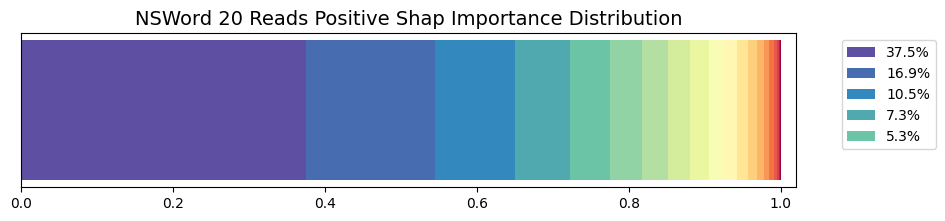

positive shap gini for 20reads is: 0.6763699


In [187]:
shap_use=shap_values_20reads.copy()
shap_use[shap_values_20reads<0]=0
row_sums=shap_use.sum(axis=1,keepdims=True)
row_sums[row_sums==0]=1
normalized_shap_use=shap_use/row_sums
sorted_normalized_shap_use=np.sort(normalized_shap_use,axis=1)[:,::-1]

#importance distribution by the top N most important read
importance_20reads=sorted_normalized_shap_use.sum(axis=0,keepdims=False)/normalized_shap_use.sum()
print(importance_20reads)

cmap=plt.colormaps.get_cmap('Spectral')
colors=cmap(np.linspace(1,0,len(importance_20reads)))
fig,ax=plt.subplots(figsize=(10,2))

left=0
for i,(imp,color) in enumerate(zip(importance_20reads,colors)):
    if i<5:
        label_use=f'{imp*100:.1f}%'
    else:
        label_use=None
    ax.barh(0,width=imp,left=left,height=0.5,color=color,label=label_use)
    left+=imp
ax.set_yticks([])
ax.set_xlim([0,1.02])
ax.set_title('NSWord 20 Reads Positive Shap Importance Distribution',fontsize=14)
ax.legend(bbox_to_anchor=(1.05,1),loc='upper left')
plt.savefig('./edata/Save_drawing/NSWord_positive_shap_distribution_20reads.pdf',bbox_inches='tight')
plt.show()

gini_20reads=gini_coefficient(importance_20reads)
print('positive shap gini for 20reads is:',gini_20reads.cpu().numpy())

[0.180562 0.12716  0.098665 0.079495 0.068779 0.061    0.053935 0.048278
 0.043353 0.039258 0.035013 0.031025 0.02802  0.024527 0.021526 0.018565
 0.015211 0.012045 0.008828 0.004753]


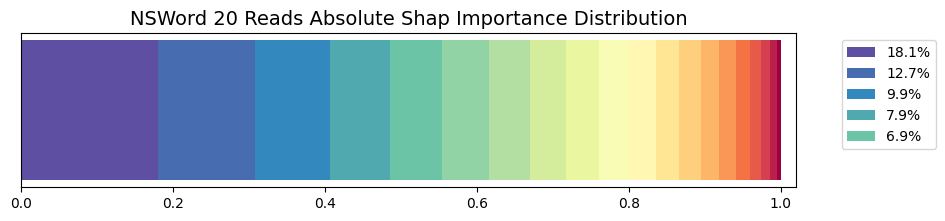

absolute shap gini for 20reads is: 0.43715


In [193]:
shap_abs=abs(shap_values_20reads.copy())
row_sums=shap_abs.sum(axis=1,keepdims=True)
normalized_shap_abs=shap_abs/row_sums
sorted_normalized_shap_abs=np.sort(normalized_shap_abs,axis=1)[:,::-1]

#importance distribution by the top N most important read
importance_20reads=sorted_normalized_shap_abs.mean(axis=0,keepdims=False)
print(importance_20reads)

cmap=plt.colormaps.get_cmap('Spectral')
colors=cmap(np.linspace(1,0,len(importance_20reads)))
fig,ax=plt.subplots(figsize=(10,2))

left=0
for i,(imp,color) in enumerate(zip(importance_20reads,colors)):
    if i<5:
        label_use=f'{imp*100:.1f}%'
    else:
        label_use=None
    ax.barh(0,width=imp,left=left,height=0.5,color=color,label=label_use)
    left+=imp
ax.set_yticks([])
ax.set_xlim([0,1.02])
ax.set_title('NSWord 20 Reads Absolute Shap Importance Distribution',fontsize=14)
ax.legend(bbox_to_anchor=(1.05,1),loc='upper left')
plt.savefig('./edata/Save_drawing/NSWord_absolute_shap_distribution_20reads.pdf',bbox_inches='tight')
plt.show()

gini_20reads=gini_coefficient(importance_20reads)
print('absolute shap gini for 20reads is:',gini_20reads.cpu().numpy())

# Shap explain 25sites

In [23]:
read_reduce=0
seq_reduce=0

background_set_25sites=[]
sample_set_25sites=[]

background_set_size=2000
sample_set_size=500
shuffled_flattened_train_set=flattened_train_set[random.sample(range(len(flattened_train_set)),background_set_size)]
shuffled_flattened_test_set=flattened_test_set[random.sample(range(len(flattened_test_set)),sample_set_size)]

for i in range(background_set_size):
    l_dic=shuffled_flattened_train_set[i]
    ap_dic={}
    if seq_reduce==0:
        ap_dic['seq_feature']=l_dic['seq_feature'].to(device)
        ap_dic['seq_mask']=l_dic['seq_mask'].to(device)
        ap_dic['nano_feature']=l_dic['nano_feature'][read_reduce:].to(device)
        ap_dic['nano_mask']=l_dic['nano_mask'][read_reduce:].to(device)
    else:
        side_reduce=int(seq_reduce/2)
        ap_dic['seq_feature']=l_dic['seq_feature'][side_reduce:-side_reduce].to(device)
        ap_dic['seq_mask']=l_dic['seq_mask'][side_reduce:-side_reduce].to(device)
        ap_dic['nano_feature']=l_dic['nano_feature'][read_reduce:,side_reduce:-side_reduce].to(device)
        ap_dic['nano_mask']=l_dic['nano_mask'][read_reduce:,side_reduce:-side_reduce].to(device)
    background_set_25sites.append(ap_dic)

for i in range(sample_set_size):
    l_dic=shuffled_flattened_test_set[i]
    ap_dic={}
    ap_dic['label']=l_dic['label']
    if seq_reduce==0:
        ap_dic['seq_feature']=l_dic['seq_feature'].to(device)
        ap_dic['seq_mask']=l_dic['seq_mask'].to(device)
        ap_dic['nano_feature']=l_dic['nano_feature'][read_reduce:].to(device)
        ap_dic['nano_mask']=l_dic['nano_mask'][read_reduce:].to(device)
    else:
        side_reduce=int(seq_reduce/2)
        ap_dic['seq_feature']=l_dic['seq_feature'][side_reduce:-side_reduce].to(device)
        ap_dic['seq_mask']=l_dic['seq_mask'][side_reduce:-side_reduce].to(device)
        ap_dic['nano_feature']=l_dic['nano_feature'][read_reduce:,side_reduce:-side_reduce].to(device)
        ap_dic['nano_mask']=l_dic['nano_mask'][read_reduce:,side_reduce:-side_reduce].to(device)
    sample_set_25sites.append(ap_dic)

background_set_25sites=np.array(background_set_25sites)
sample_set_25sites=np.array(sample_set_25sites)

In [24]:
model_25sites=Nano(c_s=4,c_x=3,c_emb=16,c_hidden_att=16,c_o=1,no_heads=8,blocks_lis=[2,2,2,0,0,0],
            dropout=0.2,transition_n=2,inf=1e9,eps=1e-8,
            clear_cache_between_blocks=False).to(device)
model_25sites.load_state_dict(torch.load('./model/NSWord_222000_90_50reads_25sites.pkl',weights_only=True))

<All keys matched successfully>

In [25]:
explainer_25sites=NSWord_DeepEXP_sites(model_25sites,background_set_25sites)

shap_values_25sites=explainer_25sites.shap_values(sample_set_25sites)
shap_values_25sites=np.array(shap_values_25sites[0])
shap_values_25sites=shap_values_25sites.reshape(shap_values_25sites.shape[:-1])

Showing the highest shap values and the status of its corrensponding site.


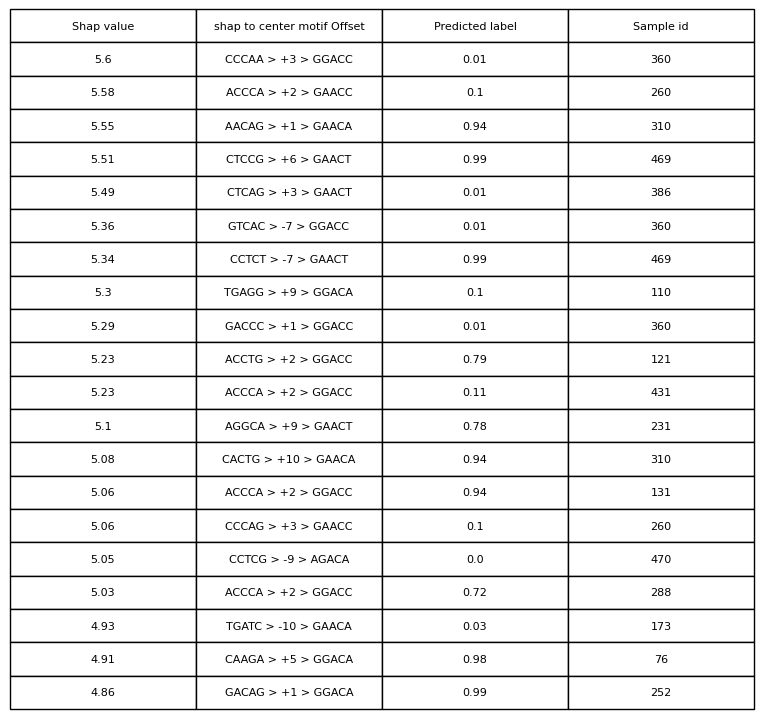

In [107]:
scaler=RobustScaler()
scaled_shap_values_25sites=scaler.fit_transform(shap_values_25sites)
read_reduce,seq_reduce=0,0
pre_Y_list,real_Y_list=[],[]
for i in range(len(scaled_shap_values_25sites)):
    l_dic=shuffled_flattened_test_set[i]
    u_dic={}
    real_Y=l_dic['label'].cpu().detach().numpy()
    real_Y_list.append(real_Y)
    ap_dic={}
    if seq_reduce==0:
        u_dic['seq_feature']=l_dic['seq_feature'].to(device)
        u_dic['seq_mask']=l_dic['seq_mask'].to(device)
        u_dic['nano_feature']=l_dic['nano_feature'][read_reduce:].to(device)
        u_dic['nano_mask']=l_dic['nano_mask'][read_reduce:].to(device)
    else:
        side_reduce=int(seq_reduce/2)
        u_dic['seq_feature']=l_dic['seq_feature'][side_reduce:-side_reduce].to(device)
        u_dic['seq_mask']=l_dic['seq_mask'][side_reduce:-side_reduce].to(device)
        u_dic['nano_feature']=l_dic['nano_feature'][read_reduce:,side_reduce:-side_reduce].to(device)
        u_dic['nano_mask']=l_dic['nano_mask'][read_reduce:,side_reduce:-side_reduce].to(device)
    pre_Y=model_25sites(u_dic['seq_feature'],u_dic['nano_feature'],u_dic['seq_mask'],u_dic['nano_mask']).cpu().detach().numpy()
    pre_Y_list.append(pre_Y)
    real_Y=l_dic['label'].cpu().detach().numpy()
    real_Y_list.append(real_Y)
pre_Y_list=np.array(pre_Y_list)
real_Y_list=np.array(real_Y_list)

TOP_N=100
print('Showing the highest shap values and the status of its corrensponding site.')
flattened_shap_values_25sites=scaled_shap_values_25sites.flatten()
top_indices=np.argsort(flattened_shap_values_25sites)[-TOP_N:]
rows,cols=np.unravel_index(top_indices,scaled_shap_values_25sites.shape)

chars=['A','T','C','G']
shap_list=[]
dist_string_list=[]
predicted_list=[]
sample_list=[]
for row,col in zip(rows[::-1],cols[::-1]):
    indices=torch.argmax(sample_set_25sites[row]['seq_feature'],dim=1)
    seq=''.join([chars[idx] for idx in indices])
    center_motif=seq[10:15]
    shap_motif=seq[max(col-2,0):col+3]
    dist_string=f'{shap_motif} > {col-12:+} > {center_motif}'
    
    dist_string_list.append(dist_string)
    shap_list.append(round(scaled_shap_values_25sites[row,col],2))
    predicted_list.append(round(pre_Y_list[row],2))
    sample_list.append(row)

fig,ax=plt.subplots()
ax.axis('tight')
ax.axis('off')
column_names=('Shap value','shap to center motif Offset','Predicted label','Sample id')
textdata=np.array([shap_list,dist_string_list,predicted_list,sample_list]).T

#only part of the table is showed
table=ax.table(cellText=textdata[45:65],colLabels=column_names,loc='center')
for key,cell in table.get_celld().items():
    cell.set_text_props(ha='center',va='center')
    cell.pad=0
table.scale(1.5,2)
plt.savefig('./edata/Save_drawing/NSWord_site_shap_table.pdf',bbox_inches='tight')
plt.show()

In [110]:
statistics_dic={}
for each in textdata:
    items=each[1].split('>')
    items=[item.strip() for item in items]
    if (items[0],items[2]) not in statistics_dic:
        statistics_dic[(items[0],items[2])]={}
    if items[1] not in statistics_dic[(items[0],items[2])]:
        statistics_dic[(items[0],items[2])][items[1]]=[]
    statistics_dic[(items[0],items[2])][items[1]].append((each[0],each[3]))

In [111]:
statistics_dic

{('GCCTA', 'AGACA'): {'-9': [('24.68', '21')]},
 ('GCG', 'GAACA'): {'-12': [('22.99', '310')]},
 ('GCCCG', 'GGACA'): {'-9': [('21.09', '306')]},
 ('GTCCT', 'GGACA'): {'+8': [('13.38', '438')]},
 ('GATGT', 'GGACA'): {'+5': [('12.83', '438')]},
 ('ACTC', 'AGACA'): {'+11': [('12.43', '21')]},
 ('CTC', 'AGACA'): {'+12': [('12.03', '21')]},
 ('ATGTC', 'GGACA'): {'+6': [('11.95', '438')]},
 ('CCTAC', 'AGACA'): {'-8': [('11.06', '21')]},
 ('GATGG', 'GGACC'): {'+10': [('10.62', '338')]},
 ('GACCA', 'GAACA'): {'+7': [('10.09', '310')]},
 ('TCT', 'GGACA'): {'+12': [('9.07', '438')]},
 ('ACAGA', 'GGACA'): {'+2': [('8.95', '438')]},
 ('CTCT', 'GGACA'): {'+11': [('8.68', '438')]},
 ('CCACT', 'GAACA'): {'+9': [('8.34', '310')]},
 ('GAACT', 'GAACT'): {'+0': [('8.31', '177')]},
 ('CAGAG', 'AGACA'): {'-3': [('8.26', '368')]},
 ('CTTCC', 'GGACA'): {'+7': [('8.25', '149')]},
 ('GACAG', 'GGACA'): {'+1': [('8.23', '438'), ('4.86', '252')]},
 ('CCTCT', 'GGACA'): {'+10': [('8.09', '438')]},
 ('TCCTC', 'GGACA

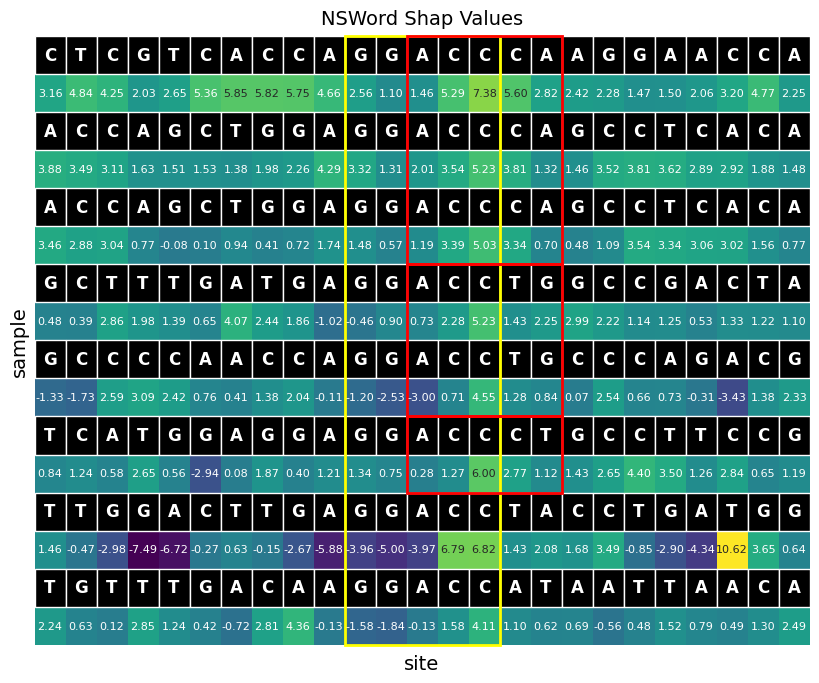

In [168]:
picked_for_showing=[360,431,288,121,283,68,338,235]
picked_reads_shap=scaled_shap_values_25sites[picked_for_showing]
arr=np.zeros((picked_reads_shap.shape[0]*2,)+ picked_reads_shap.shape[1:])
arr[1::2,:]=picked_reads_shap
mask=np.zeros_like(arr,dtype=bool)
mask[1::2,:]=True

chars=['A','T','C','G']
sequences=[]
for each in picked_for_showing:
    indices=torch.argmax(sample_set_25sites[each]['seq_feature'],dim=1)
    seq=''.join([chars[idx] for idx in indices])
    sequences.append(seq)

plt.figure(figsize=(10,8))
sns.heatmap(arr,annot=True,fmt=".2f",cmap='viridis',cbar=False,annot_kws={"size":8},mask=~mask)
sns.heatmap(arr,annot=False,fmt=".2f",cmap='viridis',cbar=False,annot_kws={"size":8},mask=mask)

ax=plt.gca()
ax.set_xticks([])
ax.set_yticks([])

for i,sequence in enumerate(sequences):
    for j,base in enumerate(sequence):
        rect=patches.Rectangle((j,2*i),1,1,linewidth=1,edgecolor='white',facecolor='black')
        ax.add_patch(rect)
        plt.text(j+0.5,2*i+0.5,base,fontsize=12,ha='center',va='center',color='white',fontweight='bold')

center_col=(len(sequences[0])-1)/2
rect=patches.Rectangle((center_col-2,0),5,len(arr),linewidth=2,edgecolor='yellow',facecolor='none')
ax.add_patch(rect)
rect=patches.Rectangle((center_col,0),5,6,linewidth=2,edgecolor='red',facecolor='none')
ax.add_patch(rect)
rect=patches.Rectangle((center_col,6),5,4,linewidth=2,edgecolor='red',facecolor='none')
ax.add_patch(rect)
rect=patches.Rectangle((center_col,10),5,2,linewidth=2,edgecolor='red',facecolor='none')
ax.add_patch(rect)

ax.set_ylim(arr.shape[0]+0.1,-0.1)


plt.title('NSWord Shap Values',fontsize=14)
plt.xlabel('site',fontsize=14)
plt.ylabel('sample',fontsize=14)
plt.savefig('./edata/Save_drawing/NSWord_shap_25sites_showcase1.pdf',bbox_inches='tight')
plt.show()

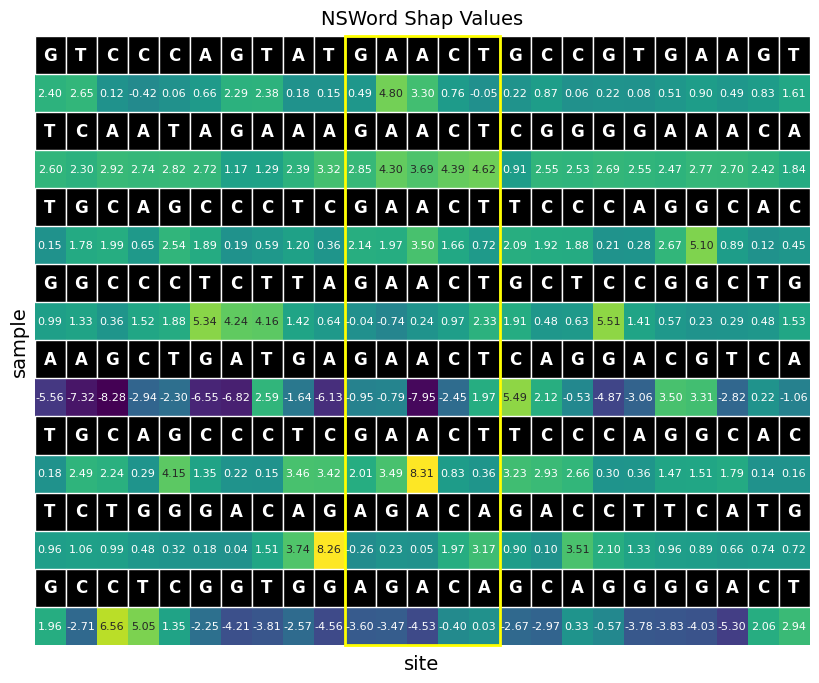

In [170]:
picked_for_showing=[186,202,231,469,386,177,368,470]
picked_reads_shap=scaled_shap_values_25sites[picked_for_showing]
arr=np.zeros((picked_reads_shap.shape[0]*2,)+ picked_reads_shap.shape[1:])
arr[1::2,:]=picked_reads_shap
mask=np.zeros_like(arr,dtype=bool)
mask[1::2,:]=True

chars=['A','T','C','G']
sequences=[]
for each in picked_for_showing:
    indices=torch.argmax(sample_set_25sites[each]['seq_feature'],dim=1)
    seq=''.join([chars[idx] for idx in indices])
    sequences.append(seq)

plt.figure(figsize=(10,8))
sns.heatmap(arr,annot=True,fmt=".2f",cmap='viridis',cbar=False,annot_kws={"size":8},mask=~mask)
sns.heatmap(arr,annot=False,fmt=".2f",cmap='viridis',cbar=False,annot_kws={"size":8},mask=mask)

ax=plt.gca()
ax.set_xticks([])
ax.set_yticks([])

for i,sequence in enumerate(sequences):
    for j,base in enumerate(sequence):
        rect=patches.Rectangle((j,2*i),1,1,linewidth=1,edgecolor='white',facecolor='black')
        ax.add_patch(rect)
        plt.text(j+0.5,2*i+0.5,base,fontsize=12,ha='center',va='center',color='white',fontweight='bold')

center_col=(len(sequences[0])-1)/2
rect=patches.Rectangle((center_col-2,0),5,len(arr),linewidth=2,edgecolor='yellow',facecolor='none')
ax.add_patch(rect)


ax.set_ylim(arr.shape[0]+0.1,-0.1)


plt.title('NSWord Shap Values',fontsize=14)
plt.xlabel('site',fontsize=14)
plt.ylabel('sample',fontsize=14)
plt.savefig('./edata/Save_drawing/NSWord_shap_25sites_showcase2.pdf',bbox_inches='tight')
plt.show()

[0.054852 0.035148 0.033212 0.03922  0.037381 0.050343 0.038354 0.020812
 0.022851 0.028803 0.040396 0.056323 0.116391 0.034314 0.035088 0.036435
 0.053754 0.03977  0.034294 0.040824 0.030315 0.032087 0.030124 0.025285
 0.033624]


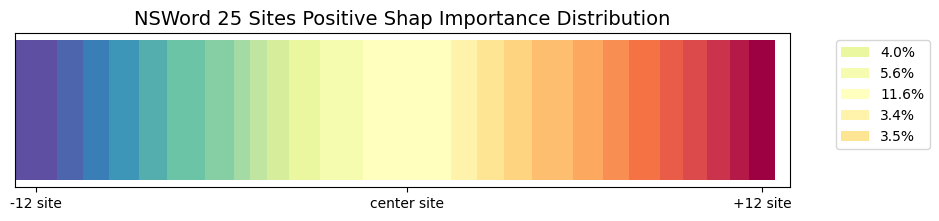

positive shap gini for 25sites is: 0.19163024


In [186]:
shap_use=shap_values_25sites.copy()
shap_use[shap_values_25sites<0]=0
row_sums=shap_use.sum(axis=1,keepdims=True)
row_sums[row_sums==0]=1
normalized_shap_use=shap_use/row_sums

#importance distribution by each site, from -12 site to the center site, in the end, to +12 sites
importance_25sites=normalized_shap_use.sum(axis=0,keepdims=False)/normalized_shap_use.sum()
print(importance_25sites)

cmap=plt.colormaps.get_cmap('Spectral')
colors=cmap(np.linspace(1,0,len(importance_25sites)))
fig,ax=plt.subplots(figsize=(10,2))

left=0
for i,(imp,color) in enumerate(zip(importance_25sites,colors)):
    if i>=10 and i<=14:
        label_use=f'{imp*100:.1f}%'
    else:
        label_use=None
    ax.barh(0,width=imp,left=left,height=0.5,color=color,label=label_use)
    left+=imp
ax.set_yticks([])

center_pos=importance_25sites[:12].sum()+importance_25sites[12]/2
left_pos=importance_25sites[0]/2
right_pos=1-importance_25sites[-1]/2
plt.xticks(ticks=[center_pos,left_pos,right_pos], labels=['center site','-12 site','+12 site'])
ax.set_xlim([0,1.02])

ax.set_title('NSWord 25 Sites Positive Shap Importance Distribution',fontsize=14)
ax.legend(bbox_to_anchor=(1.05,1),loc='upper left')
plt.savefig('./edata/Save_drawing/NSWord_positive_shap_distribution_25sites.pdf',bbox_inches='tight')
plt.show()

gini_25sites=gini_coefficient(importance_25sites)
print('positive shap gini for 25sites is:',gini_25sites.cpu().numpy())